In [1]:
# 사용할 모델 불러오기
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_csv('./UCI SECOM_sub.csv')

print(data.shape)

(1567, 308)


## Under-Sampling

 - Pass/Fail 데이터 분리

In [3]:
failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [4]:
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [5]:
# Pass 데이터에서 무작위로 104개 추출
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [6]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [7]:
undersample_data = data.iloc[under_sample, :]

In [8]:
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 307)
(208, 1)


In [9]:
# train, test 분리
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 307)
(145, 1)
(63, 307)
(63, 1)


In [10]:
# 표준화
sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

## XGBoost(Under-Sampling)

In [11]:
# XGBoost 모델 오류로 인해 y_train_us 모델 변형
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_us = le.fit_transform(y_train_us)

c:\python38\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# XGB 모델 적용
model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)

In [13]:
# 혼동행렬 적용을 위해 y_train_us 복구
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(x_test_us)
y_pred = le.inverse_transform(y_pred)
CM = confusion_matrix(y_test_us, y_pred)
print(CM)
accuracy_score(y_test_us, y_pred)

[[16 13]
 [13 21]]


0.5873015873015873

<Axes: >

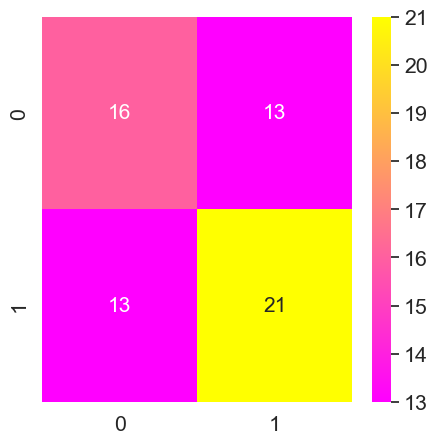

In [15]:
# 혼동행렬 시각화
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

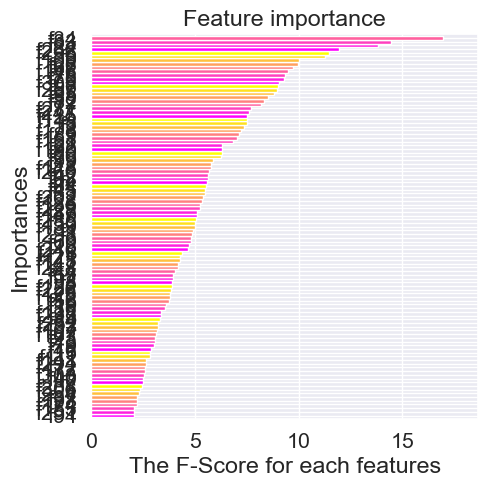

In [16]:
# 중요도 시각화
colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (100, 100)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

# Over-Sampling

In [17]:
# SMOTE 를 이용한 오버샘플링
from imblearn.over_sampling import SMOTE

x_resample, y_resample  = SMOTE().fit_resample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(220, 307)
(220,)


In [18]:
# train, test 모델 분리
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 307)
(145, 1)
(63, 307)
(63, 1)


In [19]:
# 표준화
sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

## XGBoost(Over-Sampling)

In [20]:
# XGBoost 모델 오류로 인해 y_train_us 모델 변형
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_os = le.fit_transform(y_train_os)

c:\python38\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# XGB 모델 적용
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)

model.fit(x_train_os, y_train_os)

y_pred_os = model.predict(x_test_os)

In [22]:
# GridSearchCV 적용(더 정확한 결과값을 얻기 위해서)
from sklearn.model_selection import GridSearchCV

# 매개변수 목록
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

# GridSearch 모델 
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

[10:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "cv" } are not used.



In [23]:
# 최적의 조건 산출
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.6551724137931034
Best Parameter:  {'cv': 2, 'max_depth': 5, 'random_state': 1}


In [24]:
# 최적의 조건 적용해서 XGBoost 모델 적용
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 5, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

[10:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "cv", "scale_pos_weights" } are not used.



In [25]:
# 혼동행렬 적용을 위해 y_train_us 복구
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_os = model.predict(x_test_os)
y_pred_os = le.inverse_transform(y_pred_os)
CM = confusion_matrix(y_test_os, y_pred_os)
print(CM)
accuracy_score(y_test_os, y_pred_os)

[[17 12]
 [14 20]]


0.5873015873015873

<Axes: >

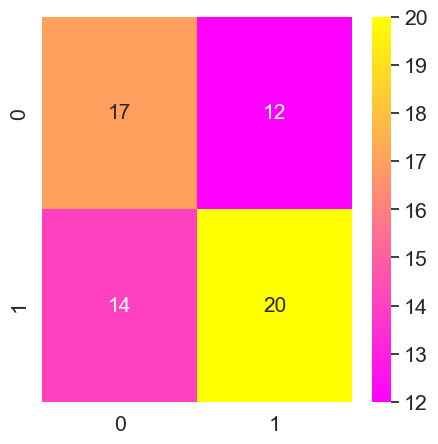

In [28]:
# 혼동행렬 적용
CM = confusion_matrix(y_test_os, y_pred_os)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(CM, annot = True, annot_kws = {"size": 15}, cmap = 'spring')